In [2]:
import autoroot
from pathlib import Path
from tqdm.auto import tqdm
from geo_toolz._src.data.ocean.ssh.alongtrack import download_alongtrack_data_new, ALONGTRACK_NAMES_NEW
from geo_toolz._src.validation.coords import validate_latitude, validate_longitude
from geo_toolz._src.subset.where import where_slice_bbox
from geo_toolz._src.validation.ssh import validate_ssh
from geo_toolz._src.kinematics.ssh import calculate_ssh_alongtrack
from geo_toolz._src.utils.io import get_list_filenames
from geo_toolz.masks import add_ocean_mask, add_land_mask
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pint_xarray
import pyinterp
import pandas as pd
from geo_toolz._src.discretize.grid import RegularLonLat, RegularLonLatTime
from geo_toolz._src.discretize.period import Period
from geo_toolz._src.discretize.binning import da_binning_2D, da_binning_2D_Time, ds_binning_2D_Time

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
lon_bnds = [-18.12, 36.25]
lat_bnds = [30.25, 46]
resolution = 1/4
target_grid = RegularLonLat.init_from_bounds(lon_bnds, lat_bnds, resolution)
target_grid

RegularLonLat(resolution=0.25, gbox=GeoBox((63, 218), Affine(0.25, 0.0, -18.25,
       0.0, -0.25, 46.0), CRS('EPSG:4326')), coordinates=<xarray.Dataset>
Dimensions:      (lat: 63, lon: 218)
Coordinates:
  * lat          (lat) float64 45.88 45.62 45.38 45.12 ... 30.88 30.62 30.38
  * lon          (lon) float64 -18.12 -17.88 -17.62 -17.38 ... 35.62 35.88 36.12
Data variables:
    spatial_ref  int32 4326)

In [4]:
time_min = "2023-01-01"
time_max = "2023-12-31"
step = 5
unit = "D"
target_grid = RegularLonLatTime.init_from_bounds(
    lon_bnds, lat_bnds, 
    resolution, 
    time_min, time_max, time_step=step, time_unit=unit)

## Data

In [5]:
ALONGTRACK_NAMES_NEW

['al', 'c2n', 'h2b', 'al', 'j3n', 's3a', 's3b', 's6a', 'swon']

Source - [cmds](https://data.marine.copernicus.eu/product/SST_MED_SST_L3S_NRT_OBSERVATIONS_010_012/description)



In [6]:
time_min = "2024-01-01"
time_max = "2024-04-01"
satellite = "l3s"

download_dir = Path("/pool/usuarios/juanjohn/data/ocean/obs/sst/")
output_directory = download_dir.joinpath(satellite)
output_directory.mkdir(exist_ok=True, parents=True)


In [7]:
import copernicusmarine
dataset_id = "SST_MED_SST_L3S_NRT_OBSERVATIONS_010_012_a"

def filter_alongtrack_times(time_min, time_max):
    return set([f"*{d.year}{d.month:02}*" for d in pd.date_range(time_min, time_max)])

filters = filter_alongtrack_times(time_min=time_min, time_max=time_max)

In [8]:
for filt in filters:
        copernicusmarine.get(
            dataset_id=dataset_id,
            filter=filt,
            output_directory=output_directory,
            force_download=True,
            overwrite_output_data=True,
        )

INFO - 2024-04-03T00:16:44Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-04-03T00:16:44Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-04-03T00:16:44Z - Service was not specified, the default one was selected: "original-files"
INFO - 2024-04-03T00:16:44Z - Downloading using service original-files...


100%|████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  6.93it/s]


INFO - 2024-04-03T00:16:54Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-04-03T00:16:54Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-04-03T00:16:54Z - Service was not specified, the default one was selected: "original-files"
INFO - 2024-04-03T00:16:54Z - Downloading using service original-files...


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.24it/s]


INFO - 2024-04-03T00:16:58Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-04-03T00:16:58Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-04-03T00:16:58Z - Service was not specified, the default one was selected: "original-files"
INFO - 2024-04-03T00:16:58Z - Downloading using service original-files...


100%|████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  7.05it/s]


INFO - 2024-04-03T00:17:07Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-04-03T00:17:07Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-04-03T00:17:07Z - Service was not specified, the default one was selected: "original-files"
INFO - 2024-04-03T00:17:07Z - Downloading using service original-files...


100%|████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:03<00:00,  8.06it/s]


In [9]:
list_of_files = get_list_filenames(output_directory, ext="*.nc")
len(list_of_files)

93

In [10]:
def pipe(ds):
    ds = validate_longitude(ds)
    ds = validate_latitude(ds)

    # select variable
    ds = ds[["sea_surface_temperature"]]
    ds = ds.rename({"sea_surface_temperature": "sst"})
    
    # validate units
    ds = ds.pint.quantify({"sst": "kelvin"})
    ds["sst"] = ds["sst"].pint.to("degC")
    ds = ds.pint.dequantify()
    # # regrid
    # ds = ds.interp(
    #     lon=target_grid.coordinates.lon,
    #     lat=target_grid.coordinates.lat,
    # )
    ds = ds.sortby("time")
    
    return ds
    

In [11]:
ds = xr.open_mfdataset(
    list_of_files, 
    preprocess=pipe,
    combine="nested",
    engine="netcdf4")

In [12]:
ds

<xarray.Dataset>
Dimensions:  (time: 93, lon: 871, lat: 253)
Coordinates:
  * time     (time) datetime64[ns] 2024-01-01 2024-01-02 ... 2024-04-02
  * lon      (lon) float32 -18.12 -18.06 -18.0 -17.94 ... 36.12 36.19 36.25
  * lat      (lat) float32 30.25 30.31 30.38 30.44 ... 45.81 45.88 45.94 46.0
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(93, 253, 871), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                CF-1.4
    title:                      Mediterranean SST, L3S, 1/16deg daily (SST_ME...
    summary:                    The MED CNR Sea Surface Temperature L3S produ...
    references:                 Buongiorno Nardelli, B., C. Tronconi, a. Pisa...
    institution:                GOS (Global Ocean Satellite monitoring and ma...
    history:                    GOS-MYO processor V3: new version
    ...                         ...
    publisher_url:              http://marine.copernicus.eu/
    publisher_email:            servicedesk.cmems@mercator-ocean.eu, gsdk@art...
    processing_level:           L3
    cdm_data_type:              grid
    Citation:                   ---
    distribution_statement:     See Copernicus Marine Service Data License

In [13]:
save_dir = "/pool/usuarios/juanjohn/data/ocean/obs/sst/clean/demo_sst_gaps_2024.nc"


In [15]:
ds.to_netcdf(save_dir)

## Gap-Filled Data

In [16]:
dataset_id = "SST_MED_SST_L4_NRT_OBSERVATIONS_010_004_a_V2"
time_min = "2024-01-01"
time_max = "2024-04-01"
satellite = "l4"

download_dir = Path("/pool/usuarios/juanjohn/data/ocean/obs/sst/")
output_directory = download_dir.joinpath(satellite)
output_directory.mkdir(exist_ok=True, parents=True)


In [17]:
for filt in filters:
        copernicusmarine.get(
            dataset_id=dataset_id,
            filter=filt,
            output_directory=output_directory,
            force_download=True,
            overwrite_output_data=True,
        )

INFO - 2024-04-03T00:19:06Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-04-03T00:19:06Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-04-03T00:19:06Z - Service was not specified, the default one was selected: "original-files"
INFO - 2024-04-03T00:19:06Z - Downloading using service original-files...


100%|████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:04<00:00,  7.04it/s]


INFO - 2024-04-03T00:19:14Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-04-03T00:19:14Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-04-03T00:19:14Z - Service was not specified, the default one was selected: "original-files"
INFO - 2024-04-03T00:19:14Z - Downloading using service original-files...


100%|██████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.42it/s]


INFO - 2024-04-03T00:19:18Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-04-03T00:19:18Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-04-03T00:19:18Z - Service was not specified, the default one was selected: "original-files"
INFO - 2024-04-03T00:19:18Z - Downloading using service original-files...


100%|████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.66it/s]


INFO - 2024-04-03T00:19:27Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-04-03T00:19:27Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-04-03T00:19:27Z - Service was not specified, the default one was selected: "original-files"
INFO - 2024-04-03T00:19:27Z - Downloading using service original-files...


100%|████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:03<00:00,  7.98it/s]


In [27]:
list_of_files = get_list_filenames(output_directory, ext="*.nc")
len(list_of_files)

93

In [28]:
def pipe(ds):
    ds = validate_longitude(ds)
    ds = validate_latitude(ds)

    # select variable
    ds = ds[["analysed_sst", "mask"]]
    ds = ds.rename({"analysed_sst": "sst"})
    
    # validate units
    ds = ds.pint.quantify({"sst": "kelvin"})
    ds["sst"] = ds["sst"].pint.to("degC")
    ds = ds.pint.dequantify()
    # # regrid
    # ds = ds.interp(
    #     lon=target_grid.coordinates.lon,
    #     lat=target_grid.coordinates.lat,
    # )
    ds = ds.sortby("time")
    
    return ds
    

In [29]:
ds = xr.open_mfdataset(
    list_of_files, 
    preprocess=pipe,
    combine="nested",
    engine="netcdf4")

In [30]:
ds

<xarray.Dataset>
Dimensions:  (time: 93, lon: 871, lat: 253)
Coordinates:
  * time     (time) datetime64[ns] 2024-01-01 2024-01-02 ... 2024-04-02
  * lon      (lon) float32 -18.12 -18.06 -18.0 -17.94 ... 36.12 36.19 36.25
  * lat      (lat) float32 30.25 30.31 30.38 30.44 ... 45.81 45.88 45.94 46.0
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(93, 253, 871), meta=np.ndarray>
    mask     (time, lat, lon) float32 dask.array<chunksize=(93, 253, 871), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                CF-1.4
    title:                      Mediterranean SST Analysis, L4, 1/16deg daily...
    summary:                    Daily gap-free maps (L4) at 0.0625deg. x 0.06...
    references:                 Buongiorno Nardelli, B., C. Tronconi, a. Pisa...
    institution:                GOS (Global Ocean Satellite monitoring and ma...
    history:                    GOS-MYO processor V3: new version
    ...                         ...
    project:                    Copernicus Marine Environment Monitoring Serv...
    publisher_name:             CNR ISMAR GOS - CMEMS SST-TAC
    publisher_url:              http://marine.copernicus.eu/
    publisher_email:            servicedesk.cmems@mercator-ocean.eu, gsdk@art...
    processing_level:           L4
    cdm_data_type:              grid

In [31]:
ds = add_ocean_mask(ds, "Mediterranean Sea")
# ds = add_land_mask(ds)
# ds = ds.where(ds.ocean_mask, drop=True)

In [35]:
ds

<xarray.Dataset>
Dimensions:     (time: 93, lon: 871, lat: 253)
Coordinates:
  * time        (time) datetime64[ns] 2024-01-01 2024-01-02 ... 2024-04-02
  * lon         (lon) float32 -18.12 -18.06 -18.0 -17.94 ... 36.12 36.19 36.25
  * lat         (lat) float32 30.25 30.31 30.38 30.44 ... 45.81 45.88 45.94 46.0
    ocean_mask  (lat, lon) int16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    sst         (time, lat, lon) float32 dask.array<chunksize=(93, 253, 871), meta=np.ndarray>
    mask        (time, lat, lon) float32 dask.array<chunksize=(93, 253, 871), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                CF-1.4
    title:                      Mediterranean SST Analysis, L4, 1/16deg daily...
    summary:                    Daily gap-free maps (L4) at 0.0625deg. x 0.06...
    references:                 Buongiorno Nardelli, B., C. Tronconi, a. Pisa...
    institution:                GOS (Global Ocean Satellite monitoring and ma...
    history:                    GOS-MYO processor V3: new version
    ...                         ...
    project:                    Copernicus Marine Environment Monitoring Serv...
    publisher_name:             CNR ISMAR GOS - CMEMS SST-TAC
    publisher_url:              http://marine.copernicus.eu/
    publisher_email:            servicedesk.cmems@mercator-ocean.eu, gsdk@art...
    processing_level:           L4
    cdm_data_type:              grid

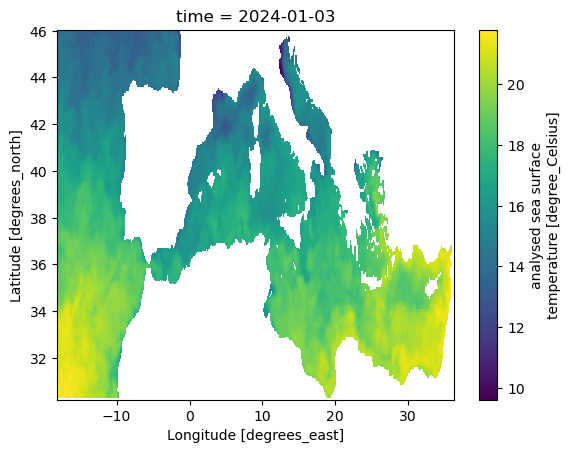

In [36]:
ds.sst.isel(time=2).plot.pcolormesh()

In [37]:
save_dir = "/pool/usuarios/juanjohn/data/ocean/obs/sst/clean/demo_sst_filled_2024.nc"


In [38]:
ds.to_netcdf(save_dir)